In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.6.2
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.6.2
keras.api._v2.keras 2.6.0


In [9]:
!ls  # 学会使用在jupyter中使用linux命令

dnn-bn-callbacks
dnn-callbacks
tf01_keras_classification_model.ipynb
tf02_keras_classification_model_1-normalize.ipynb
tf02_keras_classification_model_2-callbacks.ipynb
tf03_keras_regression.ipynb
tf04_keras_classification_model-dnn.ipynb
tf05_keras_classification_model-dnn-batch_normalization.ipynb
tf06_keras_classification_model-dnn-selu.ipynb
tf07_keras_classification_model-dnn-selu-dropout.ipynb
tf_references


In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [11]:
# 多数与上个例子一致
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [12]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Tensorboard, EarlyStopping, ModelCheckpoint
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
    
# 模型保存路径
output_model_file = os.path.join(logdir,
                                "fashion_mnist_model.h5")

callbacks = [  # 是个列表
    keras.callbacks.TensorBoard(logdir),  # 画图使用
    keras.callbacks.ModelCheckpoint(output_model_file,  # save the model after every epoch
                                   save_best_only=True),  # 保存模型的最佳参数？
    # 可以继续调小min_delta（训练时间变长），默认监控的指标是验证集的monitor='val_loss'
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2),
]

# 如果没有触发EarlyStopping，灵活把epochs改大一些
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)  # 添加callbacks参数

Epoch 1/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9286 - accuracy: 0.6983 - val_loss: 0.6203 - val_accuracy: 0.7924
Epoch 2/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5823 - accuracy: 0.8029 - val_loss: 0.5225 - val_accuracy: 0.8168
Epoch 3/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5136 - accuracy: 0.8228 - val_loss: 0.4777 - val_accuracy: 0.8360
Epoch 4/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4773 - accuracy: 0.8339 - val_loss: 0.4541 - val_accuracy: 0.8458
Epoch 5/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4535 - accuracy: 0.8415 - val_loss: 0.4388 - val_accuracy: 0.8486
Epoch 6/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4360 - accuracy: 0.8481 - val_loss: 0.4228 - val_accuracy: 0.8544
Epoch 7/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4221 - accuracy: 0.8522 - val_loss: 0.4146 - val_ac

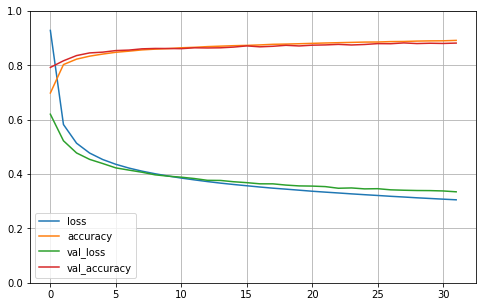

In [15]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [16]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.37158241868019104, 0.8669000267982483]

In [17]:
model.variables

[<tf.Variable 'dense_3/kernel:0' shape=(784, 300) dtype=float32, numpy=
 array([[-0.00225326,  0.01989195,  0.06622091, ..., -0.01340477,
          0.06319868, -0.01898899],
        [ 0.03350068, -0.05431915, -0.00078322, ...,  0.05729371,
          0.06444138,  0.06420592],
        [-0.04190251, -0.02907339,  0.05914751, ..., -0.01473938,
         -0.06152744,  0.02117028],
        ...,
        [-0.03629514,  0.0495684 ,  0.05274023, ..., -0.05998831,
         -0.01020051, -0.01324955],
        [ 0.06781282,  0.01224118, -0.00193003, ..., -0.03352517,
         -0.00141183, -0.02622236],
        [-0.05019118,  0.05242601,  0.03283592, ...,  0.04022184,
          0.0589495 , -0.07313962]], dtype=float32)>,
 <tf.Variable 'dense_3/bias:0' shape=(300,) dtype=float32, numpy=
 array([-2.80618062e-03,  7.62789801e-04,  5.16363536e-04,  2.13091169e-03,
        -1.48029497e-03,  5.50521538e-03,  9.79713514e-04,  8.94828793e-03,
        -4.40675626e-03, -1.19758002e-03,  7.14281155e-03,  2.26144